In [1]:
import kagglehub
import tensorflow as tf
# Download latest version
path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'eye-diseases-classification' dataset.
Path to dataset files: /kaggle/input/eye-diseases-classification


In [2]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2, PIL, glob, pathlib

In [4]:
normal = pathlib.Path(path) / "dataset" / "normal"
glaucoma = pathlib.Path(path) / "dataset" / "glaucoma"
retinopathy = pathlib.Path(path) / "dataset" / "diabetic_retinopathy"
cataract = pathlib.Path(path) / "dataset" / "cataract"

In [5]:
images_dict = {"normal": list(normal.glob("*.jpg")),
              "glaucoma": list(glaucoma.glob("*.jpg")),
              "diabetic_retinopathy":list(retinopathy.glob("*.jpeg")),
              "cataract":list(cataract.glob("*.jpg"))}
labels_dict = {
    "normal":0, "glaucoma":1, "diabetic_retinopathy":2, "cataract":3
}

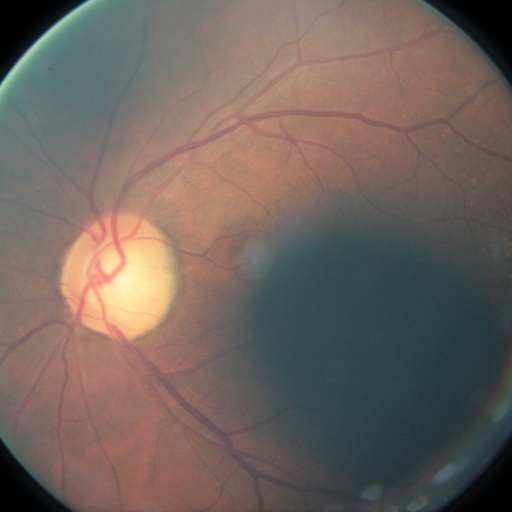

In [6]:
PIL.Image.open(str(images_dict["diabetic_retinopathy"][10]))


In [35]:
# Create file paths and labels
file_paths = []
labels = []

for label, images in images_dict.items():
    for image_path in images:
        file_paths.append(str(image_path))
        labels.append(labels_dict[label])

# Split into train and test with STRATIFICATION
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels,
    test_size=0.15,
    random_state=42,
    stratify=labels  # Ensures equal class distribution
)

# Verify no overlap
train_set = set(train_paths)
test_set = set(test_paths)
overlap = train_set.intersection(test_set)
print(f"Train samples: {len(train_paths)}")
print(f"Test samples: {len(test_paths)}")
print(f"Overlap: {len(overlap)}")  # Should be 0
assert len(overlap) == 0, "ERROR: Train and test sets overlap!"

Train samples: 3413
Test samples: 603
Overlap: 0


In [41]:
def parse_image(file_path, label, augment=False):
    """Load and preprocess image"""
    img = tf.io.read_file(file_path)
    try:
        img = tf.image.decode_jpeg(img, channels=3)
    except:
        img = tf.image.decode_image(img, channels=3)

    img = tf.image.resize(img, [256, 256])
    img = tf.cast(img, tf.float32)  # Don't normalize yet!

    # Apply augmentation on [0, 255] range
    if augment:
        # Random rotation
        k = tf.random.uniform([], 0, 4, dtype=tf.int32)
        img = tf.image.rot90(img, k)

        # Random flip
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)

        # Random brightness (works on 0-255 range)
        img = tf.image.random_brightness(img, max_delta=50)

        # Random contrast
        img = tf.image.random_contrast(img, lower=0.7, upper=1.3)

        # Random zoom (simulated with crop)
        crop_size = tf.random.uniform([], 0.8, 1.0)
        h = tf.cast(256.0 * crop_size, tf.int32)
        w = tf.cast(256.0 * crop_size, tf.int32)
        img = tf.image.random_crop(img, [h, w, 3])
        img = tf.image.resize(img, [256, 256])

    # Clip values to valid range and normalize AFTER augmentation
    img = tf.clip_by_value(img, 0, 255)
    img = img / 255.0  # Now normalize to [0, 1]

    return img, label

def create_dataset(file_paths, labels, batch_size=32, shuffle=True, augment=False):
    """Create tf.data pipeline"""
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.map(
        lambda x, y: parse_image(x, y, augment=augment),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Create datasets
BATCH_SIZE = 64  # Reduced from 128
train_dataset = create_dataset(train_paths, train_labels, BATCH_SIZE, shuffle=True, augment=True)
test_dataset = create_dataset(test_paths, test_labels, BATCH_SIZE, shuffle=False, augment=False)

# TEST the pipeline
print("Testing data pipeline...")
for images, labels in train_dataset.take(1):
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Image value range: [{images.numpy().min():.3f}, {images.numpy().max():.3f}]")
    # Should now show: [0.000, 1.000]

Testing data pipeline...
Batch shape: (64, 256, 256, 3)
Labels shape: (64,)
Image value range: [0.000, 1.000]


# BUILDING CNN model to classify **images**

In [42]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from keras.optimizers import Adam

In [46]:
# DELETE the data_argumentation cell completely

from tensorflow.keras.optimizers import Adam
from keras import Input

# DEEPER CNN for Medical Imaging
model = keras.Sequential([
    Input(shape=(256, 256, 3)),

    # Block 1
    layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),

    # Block 2
    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    # Block 3
    layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
    layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
    layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    # Block 4
    layers.Conv2D(256, (3, 3), padding="same", activation="relu"),
    layers.Conv2D(256, (3, 3), padding="same", activation="relu"),
    layers.Conv2D(256, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    # Block 5 - Deeper feature extraction
    layers.Conv2D(512, (3, 3), padding="same", activation="relu"),
    layers.Conv2D(512, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    # Classification head
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(4, activation="softmax")
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()  # Check total parameters

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,16

 Total params: 5,851,940 (22.32 MB)

 Trainable params: 5,848,420 (22.31 MB)

 Non-trainable params: 3,520 (13.75 KB)

In [47]:
import tensorflow as tf

gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:

    print("GPU is available!")
else:
    print("No GPU available. Using CPU.")

GPU is available!


In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True,
    verbose=1
)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=100, callbacks=[earlystop_cb])

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.2807 - loss: 2.2018 - val_accuracy: 0.2040 - val_loss: 1.8174
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 535ms/step - accuracy: 0.2884 - loss: 1.8236 - val_accuracy: 0.3002 - val_loss: 1.6506
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 516ms/step - accuracy: 0.3216 - loss: 1.7531 - val_accuracy: 0.2703 - val_loss: 1.5324
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 517ms/step - accuracy: 0.3430 - loss: 1.5126 - val_accuracy: 0.2736 - val_loss: 1.4629
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 528ms/step - accuracy: 0.3773 - loss: 1.4580 - val_accuracy: 0.2604 - val_loss: 1.4961
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 517ms/step - accuracy: 0.3943 - loss: 1.4336 - val_accuracy: 0.2504 - val_loss: 1.5078
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 516ms/step - accuracy: 0.4279 - loss: 1.3182 - val_accuracy: 0.2289 - val_loss: 1.5543
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 524ms/step - accuracy: 0.4642 - loss: 1.2940 - va

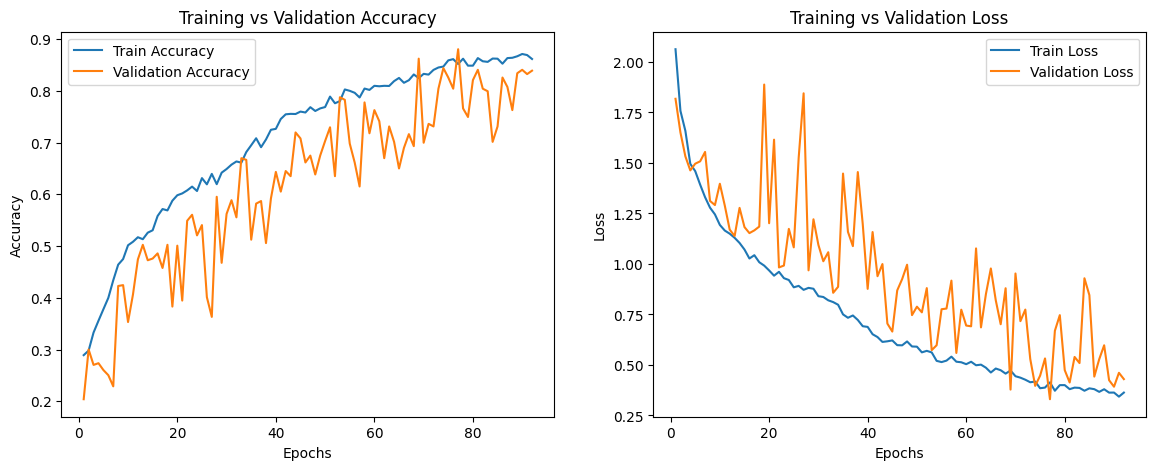

In [49]:
import matplotlib.pyplot as plt

# TRAINING CURVE VISUALIZATION
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()


Generating predictions for the test dataset...

--- Classification Report ---
                      precision    recall  f1-score   support

              normal       0.80      0.91      0.85       161
            glaucoma       0.86      0.71      0.78       136
diabetic_retinopathy       0.99      0.98      0.98       165
            cataract       0.88      0.89      0.88       141

            accuracy                           0.88       603
           macro avg       0.88      0.87      0.87       603
        weighted avg       0.88      0.88      0.88       603


Overall Accuracy: 0.8806

--- Confusion Matrix ---
[[146   6   2   7]
 [ 28  97   0  11]
 [  3   0 162   0]
 [  5  10   0 126]]


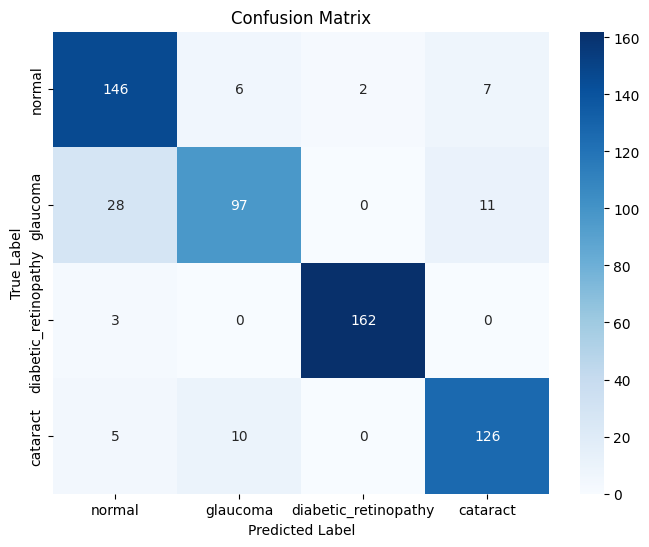


--- Per-Class Sensitivity and Specificity ---
Class 'normal':
  Sensitivity (Recall): 0.9068
  Specificity: 0.9186
Class 'glaucoma':
  Sensitivity (Recall): 0.7132
  Specificity: 0.9657
Class 'diabetic_retinopathy':
  Sensitivity (Recall): 0.9818
  Specificity: 0.9954
Class 'cataract':
  Sensitivity (Recall): 0.8936
  Specificity: 0.9610


In [54]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model_metrics(model, test_dataset, class_names):
    """Calculates and displays per-class metrics and a confusion matrix."""

    y_true = []
    y_pred = []

    print("Generating predictions for the test dataset...")
    for images, labels in test_dataset:
        predictions = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 1. Per-class metrics (Precision, Recall, F1-Score, Support)
    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # 2. Accuracy
    overall_accuracy = accuracy_score(y_true, y_pred)
    print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

    # 3. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\n--- Confusion Matrix ---")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # 4. Sensitivity (Recall) and Specificity for each class
    print("\n--- Per-Class Sensitivity and Specificity ---")
    for i, class_name in enumerate(class_names):
        # True Positives
        TP = cm[i, i]
        # False Positives
        FP = np.sum(cm[:, i]) - TP
        # False Negatives
        FN = np.sum(cm[i, :]) - TP
        # True Negatives
        TN = np.sum(cm) - TP - FP - FN

        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

        print(f"Class '{class_name}':")
        print(f"  Sensitivity (Recall): {sensitivity:.4f}")
        print(f"  Specificity: {specificity:.4f}")

# Define class names based on your labels_dict
class_names = list(labels_dict.keys())

# Call the function to evaluate the model
evaluate_model_metrics(model, test_dataset, class_names)


In [50]:
model.evaluate(test_dataset)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8848 - loss: 0.3094


[0.33021339774131775, 0.8805969953536987]

EVALUATING MODEL

In [51]:
import numpy as np

# Get a batch of test images and labels
for batch_images, batch_labels in test_dataset.take(1):
    pred = model.predict(batch_images[:10]) # predicting first 10 values
    predslist = []
    for i in pred:
        predslist.append(np.argmax(i))
    batch_images_np = batch_images[:10].numpy()
    batch_labels_np = batch_labels[:10].numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


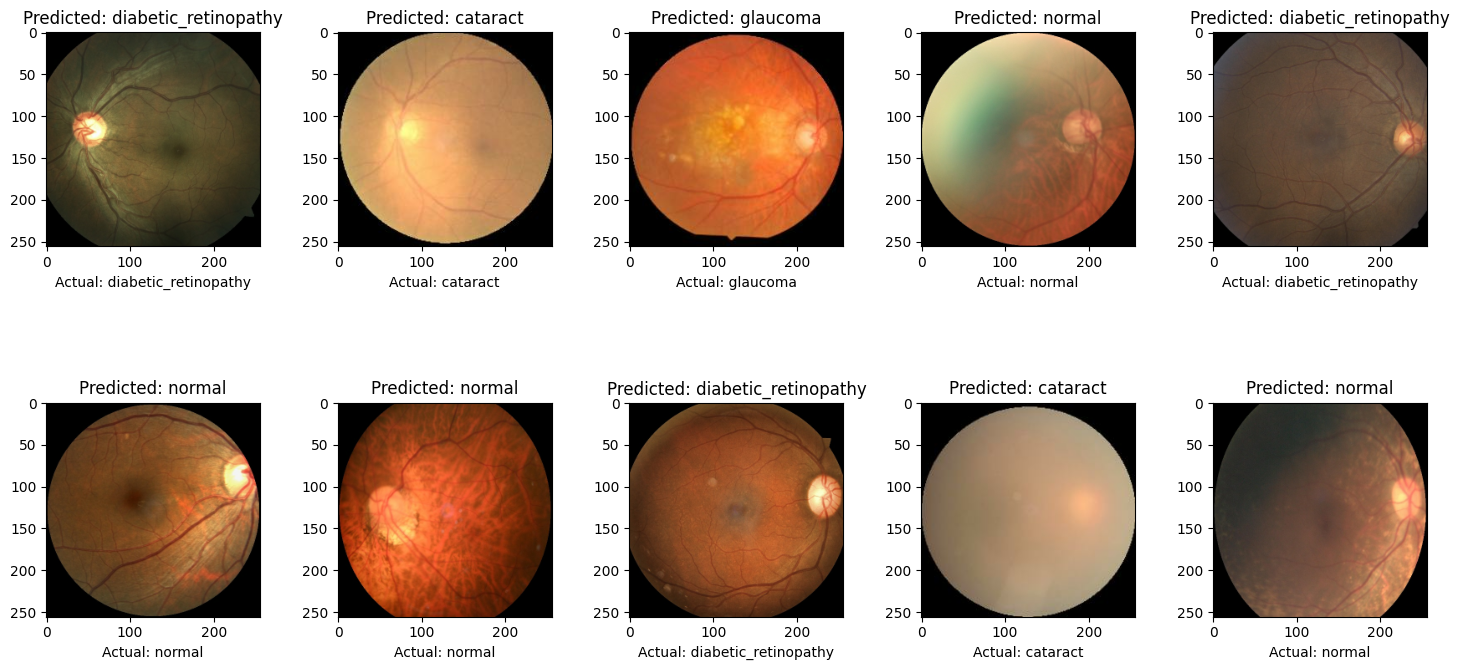

In [52]:
import matplotlib.pyplot as plt

answers = ["normal", 'glaucoma', "diabetic_retinopathy", "cataract"]

# Create a grid of subplots (2 rows, 5 columns for 10 images)
fig, axes = plt.subplots(2, 5, figsize=(15, 8)) # Increased figure height for more space
axes = axes.ravel() # Flatten the 2D array of axes for easy iteration

for i in range(10):
    axes[i].imshow(batch_images_np[i])
    axes[i].set_title("Predicted: " + str(answers[predslist[i]]))
    axes[i].set_xlabel("Actual: " + str(answers[batch_labels_np[i]]))
    axes[i].axis('on') # Hide the axes

plt.tight_layout(pad=3.0) # Adjust layout to prevent overlapping and add padding
plt.show()

In [53]:
# Save the entire model in the SavedModel format
model.save('CNNforEyeDiseasesGood.keras')